# CSI 4142 Assignment 3: Dataset 1: Housing Prices

## Group Info:
**Group #:** 120

**<u>Group Members</u>**<br>
Aydin Yalcinkaya 300238613<br>
Mustafa Ahmed 300242013<br>

# Imports and Installations
Before getting started we must perform a few installations and library imports.

Run the following installations:

In [129]:
#imports
import pandas as pd
import os.path
from datetime import datetime
import re
import numpy as np
from IPython.display import display
from rapidfuzz import fuzz
from rapidfuzz import process
from sklearn.neighbors import LocalOutlierFactor

## Report Description

The purpose of this report is to practice a predictive analysis study. The primary methodology is using Lineaer Regression.

## Housing Prices Regression Dataset
Author: Den Kuznetz

Link to the dataset: https://www.kaggle.com/datasets/denkuznetz/housing-prices-regression

Dataset use-case: dataset prepared for creating a predictive model.

### How to download:
Run the following command in the same directory as the notebook:

In [130]:
! rm housing-prices-regression.zip real_estate_dataset.csv
! curl -L -o housing-prices-regression.zip\
  https://www.kaggle.com/api/v1/datasets/download/denkuznetz/housing-prices-regression\
    && unzip housing-prices-regression.zip
! rm housing-prices-regression.zip

rm: housing-prices-regression.zip: No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 24182  100 24182    0     0  61871      0 --:--:-- --:--:-- --:--:-- 61871
Archive:  housing-prices-regression.zip
  inflating: real_estate_dataset.csv  


### Initial data output command:

In [131]:
if not os.path.exists('real_estate_dataset.csv'):
    raise Exception('Please download and extract the dataset with the command above.')
house_df = pd.read_csv('real_estate_dataset.csv')
print(house_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  500 non-null    int64  
 1   Square_Feet         500 non-null    float64
 2   Num_Bedrooms        500 non-null    int64  
 3   Num_Bathrooms       500 non-null    int64  
 4   Num_Floors          500 non-null    int64  
 5   Year_Built          500 non-null    int64  
 6   Has_Garden          500 non-null    int64  
 7   Has_Pool            500 non-null    int64  
 8   Garage_Size         500 non-null    int64  
 9   Location_Score      500 non-null    float64
 10  Distance_to_Center  500 non-null    float64
 11  Price               500 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 47.0 KB
None


In [132]:
house_df["Year_Built"].mean()

1957.604

# 1) Data Cleaning:
For our data cleaning we will perform the following cleaning checks followed by the relevant imputation/cleaning methods:

- Consistency
- Range
- Uniqueness
- Presence
- Exact Duplicates
- Near Duplicates

Due to the nature of this dataset being primarily numerical data and very minimal categorical data We will skip over the following cleaning steps as they pertain to more to categorical data: 

- Format
- Length
- Look-up

We will skip over Data Type check and cleaning as well since all the columns are strictly enforced as either int64 or float64 type which cannot be mixed up with any other data type:

- Data Type


## Consistency Check

We will check the following consistencies: 

- Garage_Size < Square_Feet
    - Pre-requisite step: convert Garage_Size from sqm to sqft

In [133]:
# Step 1: Convert Garage_Size from sqm to sqft
house_df["Garage_Size"] = house_df["Garage_Size"] * 10.7639

In [134]:
# Step 2: Consistency check: Garage_Size in sqft should be less than Square_Feet
invalid_garages = house_df[house_df["Garage_Size"] >= house_df["Square_Feet"]]

# Step 3: Display the rows that violate the condition
invalid_garages

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1,3,3,1967,1,1,516.6672,8.297631,5.935734,602134.816747
1,2,287.678577,1,2,1,1949,0,1,398.2643,6.061466,10.827392,591425.135386
4,5,89.004660,4,3,3,1999,1,0,365.9726,1.523278,14.648277,619879.142523
5,6,88.998630,5,3,2,1959,1,1,387.5004,8.994552,17.633250,670386.804433
6,7,64.520903,4,3,1,1938,0,1,344.4448,7.101354,2.429908,523827.125601
...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,165.924601,4,3,1,1935,1,1,236.8058,4.893764,15.889616,622815.455423
495,496,138.338057,2,2,2,1967,1,0,172.2224,4.296086,5.562583,488496.350722
496,497,195.914028,2,3,1,1977,0,1,484.3755,7.406261,2.845105,657736.921717
497,498,69.433659,1,1,2,2004,0,0,193.7502,8.629724,6.263264,405324.950201


### Inconsistencies found:
409 rows were found to have a larger garage than home. This seemed like a clear mixup as this makes up for approximately 82% of the dataset. Rows where the garage size is greater than the square feet of the home, these values will be swapped.

In [135]:
# Identify where Garage_Size is greater than Square_Feet
swap_condition = house_df["Garage_Size"] > house_df["Square_Feet"]

# Perform the swap PROPERLY
house_df.loc[swap_condition, ["Square_Feet", "Garage_Size"]] = (house_df.loc[swap_condition, ["Garage_Size", "Square_Feet"]].values)

Verify the swap was completed correctly. There should be no rows such that Square_Feet < Garage_Size.

Perform a check:

In [136]:
# Identify where Garage_Size is greater than Square_Feet
swap_condition =  house_df["Square_Feet"] < house_df["Garage_Size"]

# Display rows where the condition is True (Square_Feet < Garage_Size)
inconsistent_rows = house_df[swap_condition]

# Print the problematic rows
num_inconsistent = len(inconsistent_rows)

print(f"There are {num_inconsistent} rows such that Square_Feet < Garage_Size")
print("View some samples:")
inconsistent_rows

There are 0 rows such that Square_Feet < Garage_Size
View some samples:


,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price


## Range:

Given that majority of the values are int64 or float64, a range check is valuable.

### Perform the range check:

In [137]:
#Range Filters
min_sqft = 46.0
min_bed = 1
min_bath = 1
min_floors = 1
year_built_range = range(1600, 2025)
min_garage_size = 16.7225
location_score_range = (0,10)
min_dist_ctr = 0
min_price = 0

# Create a mask for valid rows
valid_mask = (
    (house_df["Square_Feet"] >= min_sqft) &
    (house_df["Num_Bedrooms"] >= min_bed) &
    (house_df["Num_Bathrooms"] >= min_bath) &
    (house_df["Num_Floors"] >= min_floors) &
    (house_df["Year_Built"].isin(year_built_range)) &
    (house_df["Garage_Size"] >= min_garage_size) &
    (house_df["Location_Score"].between(*location_score_range)) &
    (house_df["Distance_to_Center"] >= min_dist_ctr) &
    (house_df["Price"] >= min_price)
)

# Get the problematic rows
problematic_rows = house_df[~valid_mask]  # Invert mask to get failing rows

# Display the problematic rows (There should be none)
problematic_rows.head()

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price


In [138]:
num_invalid_rows_range = len(problematic_rows["Garage_Size"])
invalid_garage_vals = problematic_rows["Garage_Size"].unique()

print(f"There are {num_invalid_rows_range} rows with invalid ranges")
print(f"Invalid garage values: {invalid_garage_vals}")

There are 0 rows with invalid ranges
Invalid garage values: []


#### Invalid Garage Sizes

By logic and my research, the minimum garage size is 10x8 feet or 16.7725 Square feet. We will imputate the minumum garage size to such records

In [139]:
#Convert the Garage_Size column to a float64 type
house_df["Garage_Size"] = house_df["Garage_Size"].astype(float)

In [140]:
# Impute the invalid garage sizes with the minimum size
house_df["Garage_Size"] = house_df["Garage_Size"].apply(lambda x: max(x, 16.7225))

#### Successful Garage_Size Imputation
There should be no more range errors upon the Garage_Size imputation

## Uniqueness Check:
Only the ID Column needs to have unique values so we will verify that by ensuring the number of unique id values is the same as the length of the entire dataset. This is becsause there is a 1 to 1 relationship between the ID and each row.

In [141]:
len(house_df['ID'].unique()) == len(house_df)

True

## Presence Check:
We will check for null values in each column. Upon performing the check there are in fact none.

In [142]:
print(house_df.isna().sum())

ID                    0
Square_Feet           0
Num_Bedrooms          0
Num_Bathrooms         0
Num_Floors            0
Year_Built            0
Has_Garden            0
Has_Pool              0
Garage_Size           0
Location_Score        0
Distance_to_Center    0
Price                 0
dtype: int64


No Null values

## Duplicate Check

In [143]:
duplicates = house_df[house_df.duplicated()]

duplicates

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price


No duplicates found

## Near Duplicate Check


In [144]:
house_df_rounded = house_df.copy()

# Round numerical columns to a specific number of decimal places
numeric_columns = ['Square_Feet', 'Num_Bedrooms', 'Num_Bathrooms', 'Num_Floors', 'Year_Built', 'Garage_Size', 'Location_Score', 'Distance_to_Center', 'Price']
house_df_rounded[numeric_columns] = house_df[numeric_columns].round(2)

# Now check for duplicates in the rounded dataset
near_duplicates = house_df_rounded[house_df_rounded.duplicated()]
near_duplicates

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price


No near duplicates identified

# 2) Categorical Feature Encoding

There is already existing one-hot encoding in the Has_Garden and Has_Pool columns. All other columns are numerical therfore there can be no further categorical feature encoding.

# 3) EDA and Outlier Detection

TODO Re organize to demonstrate the EDA into LOF

In [145]:
# Get all the columns, excluding those containing 'LOF_Score'
main_columns = [col for col in house_df.columns if 'LOF_Score' not in col and 'Outl' not in col]

print(main_columns)

['ID', 'Square_Feet', 'Num_Bedrooms', 'Num_Bathrooms', 'Num_Floors', 'Year_Built', 'Has_Garden', 'Has_Pool', 'Garage_Size', 'Location_Score', 'Distance_to_Center', 'Price']


In [146]:
# Assuming house_df is your dataset

# Extract 'Num_Bedrooms' for outlier detection
X = house_df[['Num_Bedrooms']]

# Initialize Local Outlier Factor (LOF) model
lof = LocalOutlierFactor(n_neighbors=15, contamination=0.05)  # Adjust contamination as needed

# Fit and predict outliers (-1 means outlier, 1 means inlier)
outlier_flags = lof.fit_predict(X)

# Add the LOF scores and outlier labels to the dataframe
house_df["LOF_Score"] = lof.negative_outlier_factor_  # More negative = more anomalous
house_df["Is_Outlier"] = outlier_flags == -1  # True if flagged as an outlier

# Show only the detected outliers
outliers = house_df[house_df["Is_Outlier"]]

# Print the flagged outliers
print(outliers[['Num_Bedrooms', 'LOF_Score', 'Is_Outlier']])

Empty DataFrame
Columns: [Num_Bedrooms, LOF_Score, Is_Outlier]
Index: []


In [147]:
 from sklearn.neighbors import LocalOutlierFactor

# Identify numerical columns (exclude 'ID' since it's just an identifier)
num_cols = house_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop("ID")  # Drop ID column

# Set LOF parameters
n_neighbors = 20
contamination = 0.05

# Run LOF for each numerical column
for col in num_cols:
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    outliers = lof.fit_predict(house_df[[col]])
    
    # Store results in a new column for each feature
    house_df[f"LOF_Score_{col}"] = lof.negative_outlier_factor_
    house_df[f"Is_Outlier_{col}"] = outliers == -1

# Combine all outlier flags (flagged in ANY column)
house_df["Is_Outlier_Any"] = house_df[[f"Is_Outlier_{col}" for col in num_cols]].any(axis=1)

In [148]:
# Get rows where 'Is_Outlier_Year_Built' is True
outliers_year_built = house_df[house_df['Is_Outlier_Price'] == True]

# Display the rows
outliers_year_built[main_columns]


,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
7,8,419.792100,5,1,3,1973,1,1,266.544036,9.373784,12.692785,875352.545188
40,41,312.153100,1,1,2,1924,1,1,80.509559,9.306068,15.459734,352899.274264
52,53,284.874735,5,2,2,2012,1,1,226.041900,7.608543,13.945508,909199.560366
90,91,139.930700,1,1,2,1920,0,1,79.898561,2.320398,0.906386,276892.470136
102,103,387.500400,1,2,3,1901,0,0,128.588995,0.460567,8.521420,299477.849956
148,149,441.319900,1,1,2,1983,0,0,62.869688,1.438144,9.262294,280166.110934
150,151,322.917000,5,2,3,2019,1,1,277.066471,9.037576,13.094182,960678.274291
171,172,322.917000,2,1,1,1935,1,0,54.146957,7.739062,4.021303,320014.707134
179,180,387.500400,1,3,1,1901,1,1,84.380236,3.918240,14.136757,359989.957038
200,201,452.083800,5,3,2,2000,1,1,210.507912,8.180267,18.332066,885909.215276


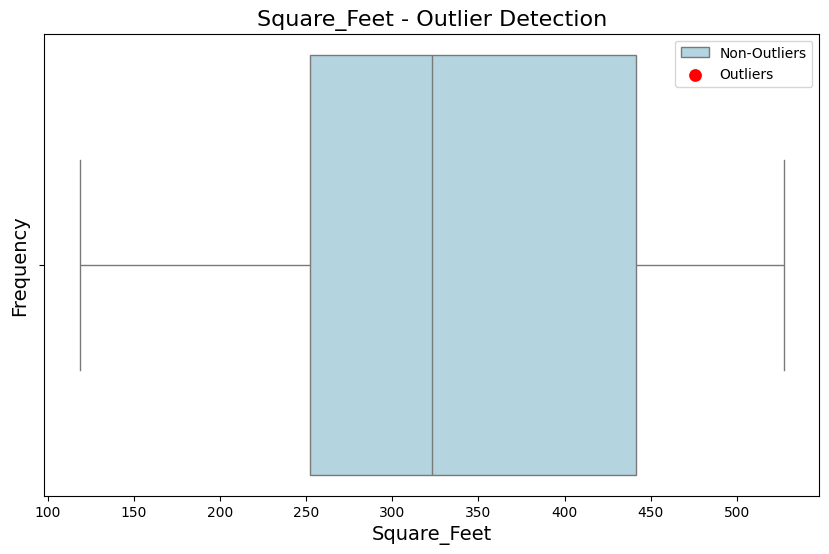

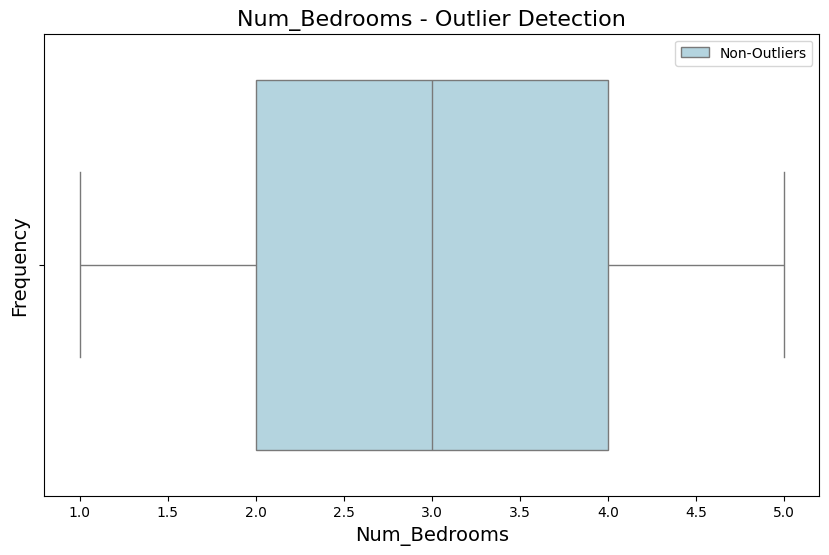

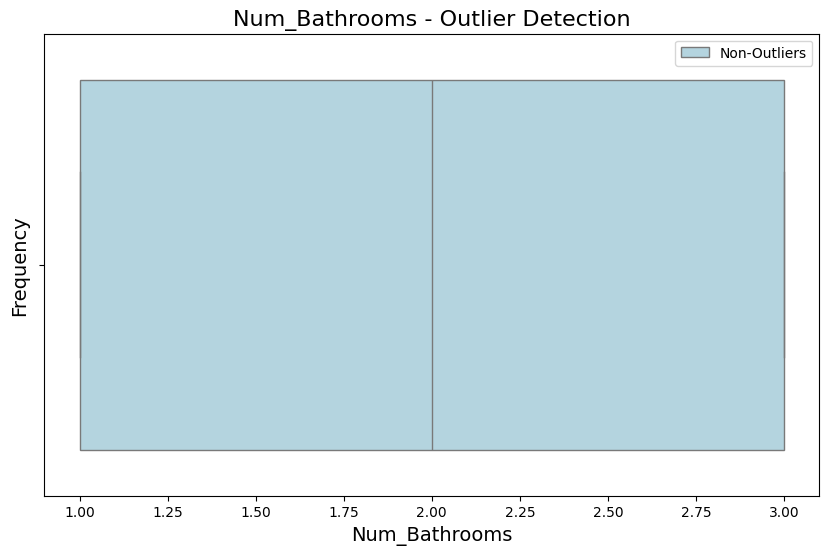

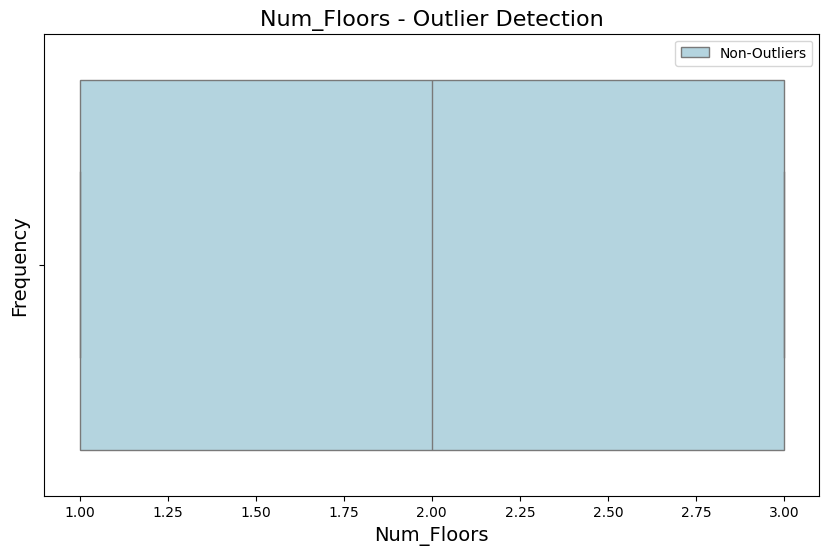

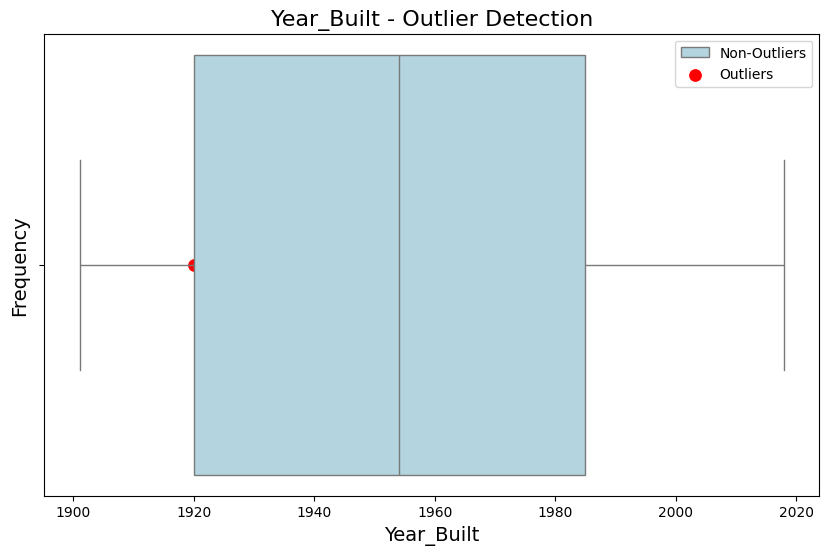

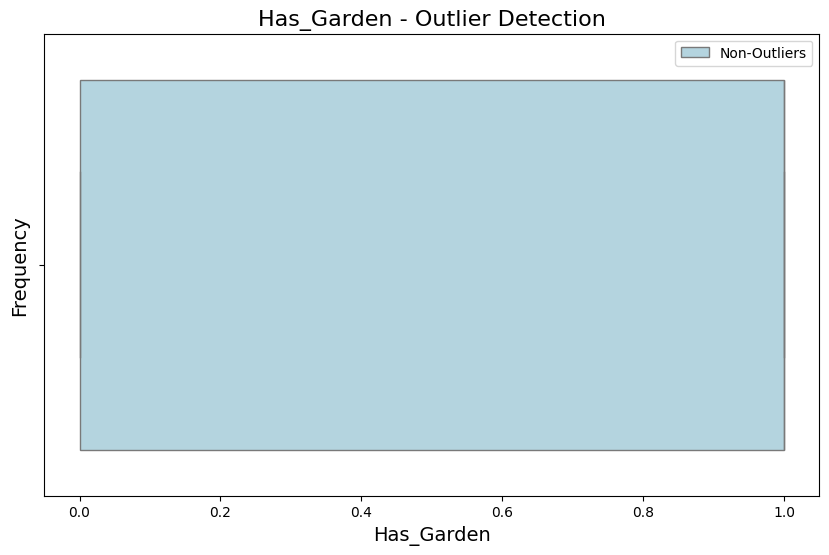

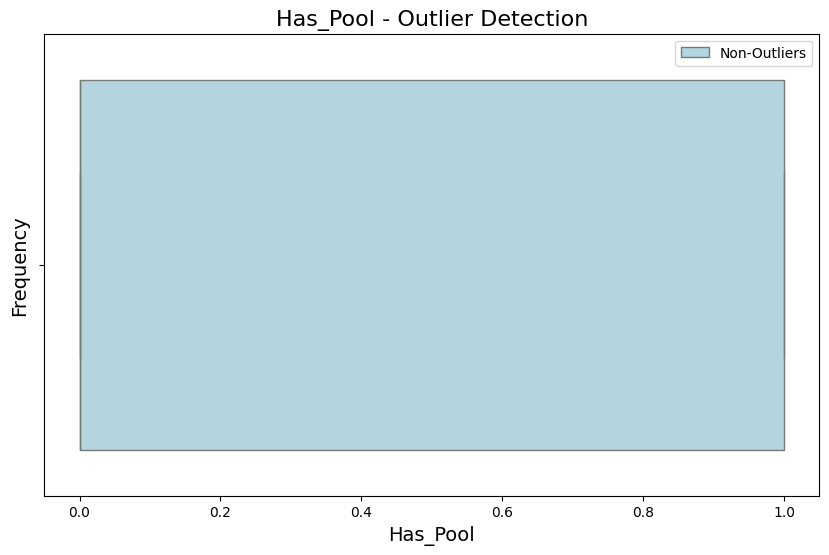

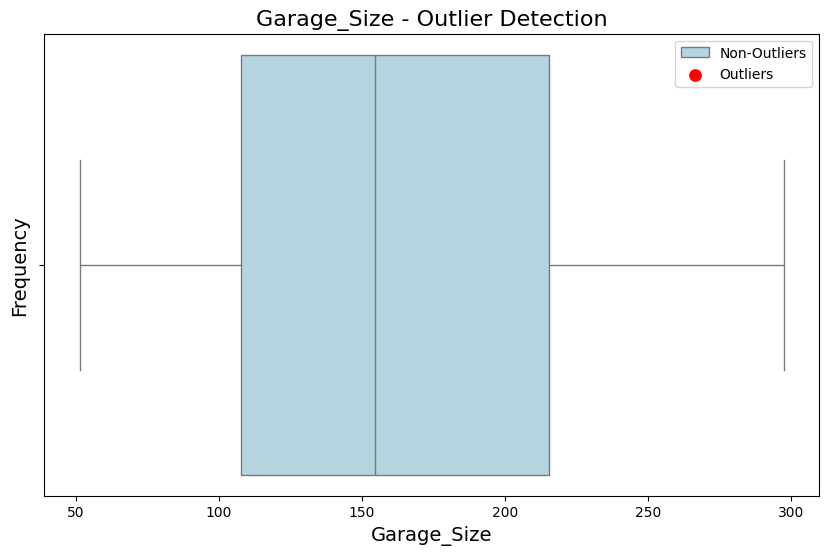

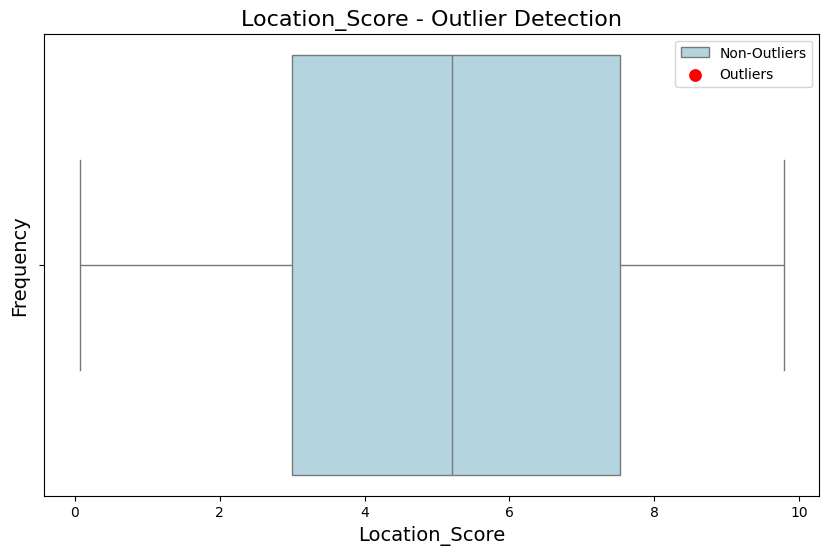

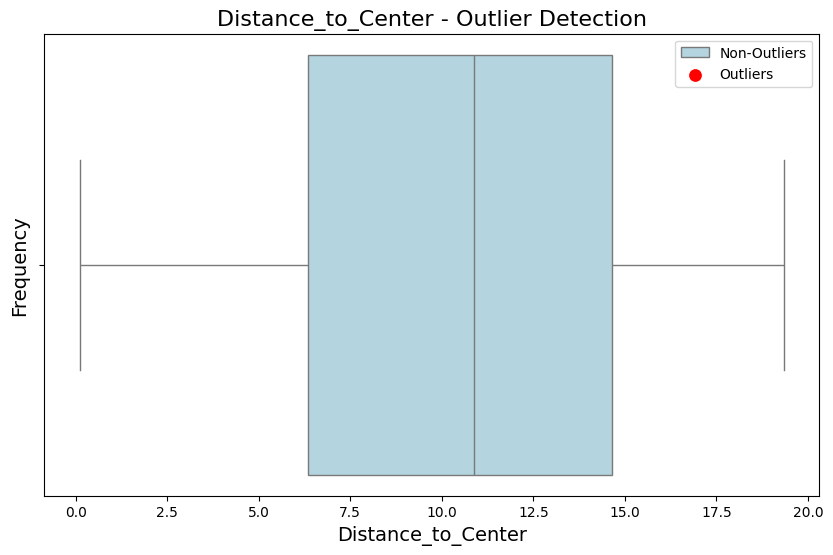

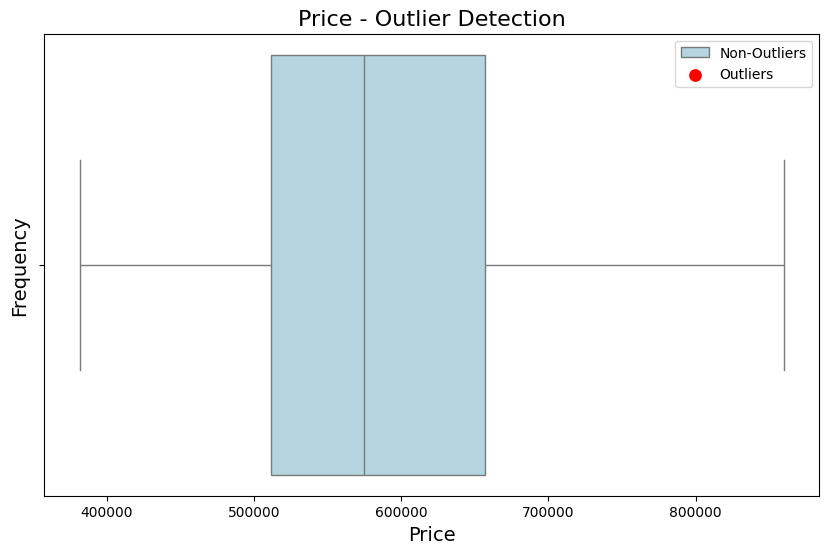

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns in the dataframe, excluding 'ID', LOF columns, and categorical columns
numerical_columns = house_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != 'ID' and 'LOF_Score' not in col]  # Skip 'ID' and LOF columns

# Loop through each numerical column and plot the boxplot with outliers
for column in numerical_columns:
    # Filter outliers and non-outliers for the current column
    outliers = house_df[house_df[f'Is_Outlier_{column}'] == True]
    non_outliers = house_df[house_df[f'Is_Outlier_{column}'] == False]

    # Set up the plot for this column
    plt.figure(figsize=(10, 6))

    # Plot the non-outliers
    sns.boxplot(x=house_df[column], color='lightblue', label='Non-Outliers')

    # Plot the outliers (overlay on the same plot)
    sns.scatterplot(x=outliers[column], y=[0] * len(outliers), color='red', marker='o', s=100, label='Outliers')

    # Title and labels
    plt.title(f'{column} - Outlier Detection', fontsize=16)
    plt.xlabel(f'{column}', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()


In [151]:
import pandas as pd

# Columns to check for outliers and perform imputation
columns_to_impute = [
    'Square_Feet', 'Num_Bedrooms', 'Num_Bathrooms', 'Num_Floors', 'Year_Built',
    'Has_Garden', 'Has_Pool', 'Garage_Size', 'Location_Score', 'Distance_to_Center', 'Price'
]

# Apply appropriate imputation method based on outlier status
for col in columns_to_impute:
    outlier_col = 'Is_Outlier_' + col

    if outlier_col in house_df.columns:
        # Use Mode for Year_Built, otherwise use Median for other numerical columns
        if col == 'Year_Built':
            imputation_value = house_df[col].mode()[0]  # Mode for Year_Built
        else:
            imputation_value = house_df[col].median()  # Median for other numerical columns

        # Apply the imputation to outlier rows
        house_df.loc[house_df[outlier_col] == True, col] = imputation_value


# Sources:
Smallest Possible House Size: https://www.greatlakestinyhome.com/worlds-smallest-house/#:~:text=Keret%20House%2C%20Poland&text=It%20boasts%20a%20world%20record,story%20on%20the%20first%20floor.

Oldest built home: https://geojango.com/blogs/explore-your-world/oldest-homes-america?srsltid=AfmBOoq0J_96cQgna1C_MJVIoC61INx0zlf6BAcT8YgHT8LzfNNKZdNC

Minumum Garage Size: https://shedsunlimited.net/blog/how-large-is-a-one-car-garage/?srsltid=AfmBOoq7cjf-SXORwozvt1vRW4ow4GMjwQg8tTLz0ldzLrky1VLNK3zc